In [12]:
# 1. Upload file CSV ke Google Colab
from google.colab import files
uploaded = files.upload()

# 2. Import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, classification_report
)

Saving income.csv to income (1).csv


In [13]:
# 3. Membaca file income.csv dan eksplorasi awal
df = pd.read_csv("income.csv")
print("5 Baris Pertama Dataset:")
display(df.head())

# 4. Cek dan hapus nilai kosong
print("\nJumlah nilai kosong per kolom:")
print(df.isnull().sum())

df = df.dropna()  # Hapus baris yang memiliki nilai kosong

# 5. Tampilkan tipe data kolom
print("\nTipe data per kolom:")
print(df.dtypes)

5 Baris Pertama Dataset:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



Jumlah nilai kosong per kolom:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Tipe data per kolom:
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


In [14]:
# 6. Label Encoding target ('income': <=50K -> 0, >50K -> 1)
le = LabelEncoder()
df['income'] = le.fit_transform(df['income'])

# 7. One-Hot Encoding untuk kolom kategorikal (drop_first=True untuk menghindari dummy trap)
df = pd.get_dummies(df, drop_first=True)

# 8. Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['income'])  # Semua kolom kecuali 'income'
y = df['income']

# 9. Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# 10. Training model K-NN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# 11. Training model Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# 12. Prediksi label
y_pred_knn = knn.predict(X_test)
y_pred_dt = dt.predict(X_test)

In [16]:
# 13. Prediksi probabilitas (untuk AUC/ROC)
y_prob_knn = knn.predict_proba(X_test)
y_prob_dt = dt.predict_proba(X_test)

# 14. Fungsi evaluasi model
def evaluate_model(name, y_true, y_pred):
    print(f"\n📌 Evaluasi Model: {name}")
    print("Akurasi  :", round(accuracy_score(y_true, y_pred), 4))
    print("Presisi  :", round(precision_score(y_true, y_pred, average='weighted'), 4))
    print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))
    print("F1 Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))

# 15. Evaluasi kedua model
evaluate_model("K-Nearest Neighbors", y_test, y_pred_knn)
evaluate_model("Decision Tree", y_test, y_pred_dt)


📌 Evaluasi Model: K-Nearest Neighbors
Akurasi  : 0.4869
Presisi  : 0.4314
Recall   : 0.4869
F1 Score : 0.4391

📌 Evaluasi Model: Decision Tree
Akurasi  : 0.4765
Presisi  : 0.4786
Recall   : 0.4765
F1 Score : 0.4775


In [17]:

# 16. Binarisasi target untuk multiclass ROC AUC (meskipun income ini biner: 0 dan 1)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# ROC Curve - K-NN
fpr_knn, tpr_knn, roc_auc_knn = dict(), dict(), dict()
for i in range(len(classes)):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_prob_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# ROC Curve - Decision Tree
fpr_dt, tpr_dt, roc_auc_dt = dict(), dict(), dict()
for i in range(len(classes)):
    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_bin[:, i], y_prob_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

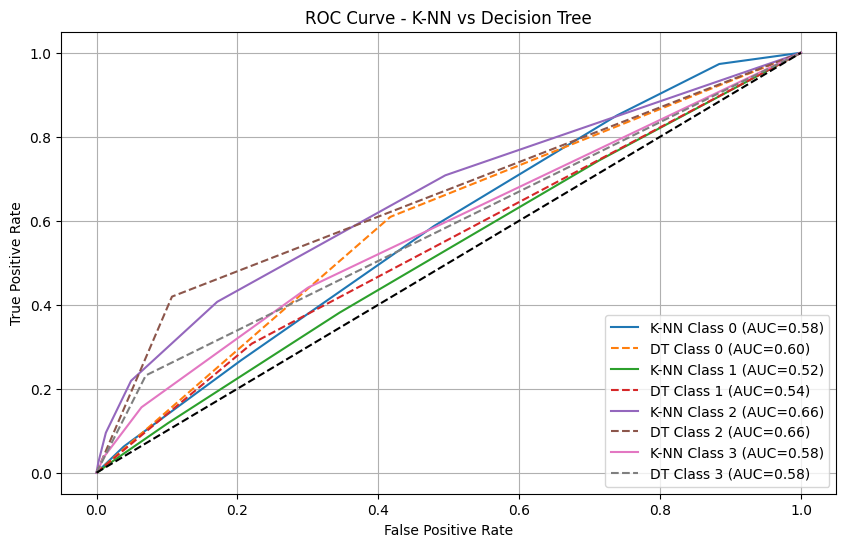

In [18]:
# 17. Plot ROC Curve
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    plt.plot(fpr_knn[i], tpr_knn[i], label=f'K-NN Class {i} (AUC={roc_auc_knn[i]:.2f})')
    plt.plot(fpr_dt[i], tpr_dt[i], linestyle='--', label=f'DT Class {i} (AUC={roc_auc_dt[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-NN vs Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [19]:
# 18. Simpan metrik evaluasi ke dalam DataFrame
results = {
    "Metrik": ["Akurasi", "Presisi", "Recall", "F1 Score", "AUC"],
    "K-NN": [
        round(accuracy_score(y_test, y_pred_knn), 2),
        round(precision_score(y_test, y_pred_knn, average='weighted'), 2),
        round(recall_score(y_test, y_pred_knn, average='weighted'), 2),
        round(f1_score(y_test, y_pred_knn, average='weighted'), 2),
        round(roc_auc_score(y_test_bin, y_prob_knn, multi_class='ovr'), 2)
    ],
    "Decision Tree": [
        round(accuracy_score(y_test, y_pred_dt), 2),
        round(precision_score(y_test, y_pred_dt, average='weighted'), 2),
        round(recall_score(y_test, y_pred_dt, average='weighted'), 2),
        round(f1_score(y_test, y_pred_dt, average='weighted'), 2),
        round(roc_auc_score(y_test_bin, y_prob_dt, multi_class='ovr'), 2)
    ]
}

df_results = pd.DataFrame(results)

# 19. Tampilkan tabel perbandingan
from IPython.display import display
print("\n📊 Perbandingan Evaluasi Model K-NN vs Decision Tree")
display(df_results.style.set_table_attributes("style='display:inline'").set_caption("Tabel Evaluasi Model"))


📊 Perbandingan Evaluasi Model K-NN vs Decision Tree


,Metrik,K-NN,Decision Tree
0,Akurasi,0.490000,0.480000
1,Presisi,0.430000,0.480000
2,Recall,0.490000,0.480000
3,F1 Score,0.440000,0.480000
4,AUC,0.580000,0.590000


# 📊 **Rumus Metrik Evaluasi Model Machine Learning**

## 1. **Akurasi (Accuracy)**

Mengukur proporsi prediksi yang benar dari seluruh data:

$$
\text{Akurasi} = \frac{TP + TN}{TP + TN + FP + FN}
$$

---

## 2. **Presisi (Precision)**

Mengukur seberapa banyak prediksi positif yang benar:

$$
\text{Presisi} = \frac{TP}{TP + FP}
$$

---

## 3. **Recall (Sensitivity / True Positive Rate)**

Mengukur seberapa banyak data positif yang berhasil diprediksi dengan benar:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

---

## 4. **F1 Score**

Harmonik rata-rata dari presisi dan recall, digunakan saat keseimbangan antara keduanya penting:

$$
\text{F1 Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}
$$

---

## 5. **False Positive Rate (FPR)**

Proporsi negatif yang salah diprediksi sebagai positif:

$$
\text{FPR} = \frac{FP}{FP + TN}
$$

---

## 6. **True Positive Rate (TPR)**

Identik dengan recall:

$$
\text{TPR} = \frac{TP}{TP + FN}
$$

---

## 7. **AUC (Area Under Curve)**

Luas di bawah kurva ROC yang menggambarkan kinerja klasifikasi probabilistik:

$$
\text{AUC} = \int_{0}^{1} \text{TPR}(x) \, dx
$$

---

## 📌 Keterangan Notasi:

| Singkatan | Arti                              |
|-----------|------------------------------------|
| TP        | True Positive (positif yang benar) |
| TN        | True Negative (negatif yang benar) |
| FP        | False Positive (positif yang salah)|
| FN        | False Negative (negatif yang salah)|

---

Kalau kamu nanti butuh bagian ini dijadikan PDF, Word, atau langsung masuk ke Bab IV (Analisis), tinggal bilang aja. Bisa juga aku bantu susun paragraf penjelasan dari hasil evaluasi model-mu.